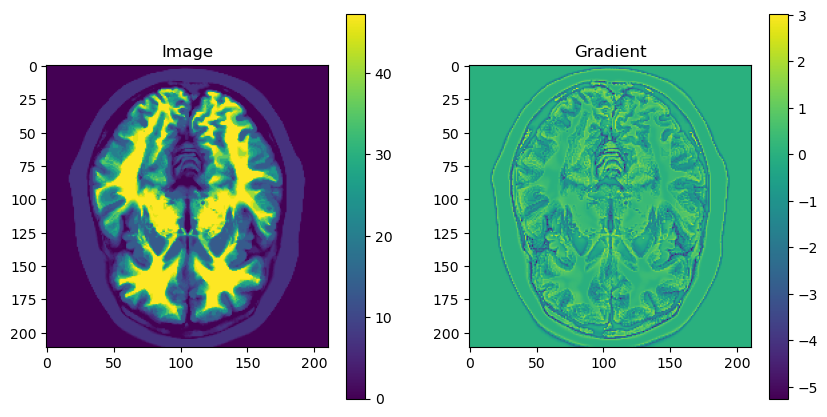

In [1]:
import sirf.STIR as pet
from sirf.STIR import RelativeDifferencePrior
import cupy as cp
pet.set_verbosity(0)
pet.AcquisitionData.set_storage_scheme("memory")
from ipywidgets import interact
import matplotlib.pyplot as plt
import time

image = pet.ImageData("/home/user/sirf/brain/emission.hv")
prior = RelativeDifferencePrior()
penalisation_factor = 1.
epsilon = 1e-9
gamma = 2
kappa = image.clone().fill(1)

prior.set_penalisation_factor(penalisation_factor)
prior.set_epsilon(epsilon)
prior.set_gamma(gamma)
prior.set_kappa(kappa)
prior.set_up(image)
sirf_grad = prior.get_gradient(image)
sirf_val = prior.get_value(image)

z = 10

#def plot_3d(z):
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.colorbar(ax[0].imshow(image.as_array()[z,:,:]), ax=ax[0])
ax[0].set_title("Image")
fig.colorbar(ax[1].imshow(sirf_grad.as_array()[z,:,:]), ax=ax[1])
ax[1].set_title("Gradient")
plt.show()

#interact(plot_3d, z=(0, image.dimensions()[0]-1, 1))


# This weight computation should take place in c++

In [2]:
# compute weights 1/euclidean norm
cp_weights = cp.zeros([3,3,3])
voxel_sizes = image.voxel_sizes()
for i in range(3):
    for j in range(3):
        for k in range(3):
            cp_weights[i,j,k] = voxel_sizes[2]/cp.sqrt(((i-1)*voxel_sizes[0])**2 + ((j-1)*voxel_sizes[1])**2 + ((k-1)*voxel_sizes[2])**2)
cp_weights[1,1,1] = 0
cp_image = cp.asarray(image.as_array(), dtype=cp.float32)
z_dim, y_dim, x_dim = cp_image.shape
cp_penalisation_factor = cp.ones(1, dtype=cp.float32)*penalisation_factor
cp_gamma = cp.ones(1, dtype=cp.float32)*gamma
cp_epsilon = cp.ones(1, dtype=cp.float32)*epsilon
cp_kappa = cp.asarray(kappa.as_array(), dtype=cp.float32)
cp_weights = cp.asarray(cp_weights, dtype=cp.float32)

Time to compute value: 0.0007317066192626953
Value from CPU: 1110913.5
Value from GPU: 1110913.5


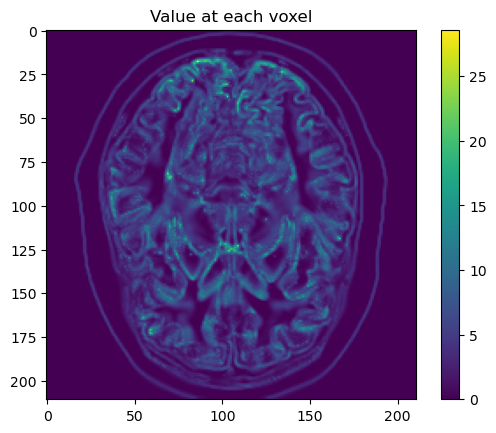

In [3]:
with open('/home/user/sirf/compute_value.cu', 'r', encoding='utf-8') as file:
    content = file.read()

compute_value = cp.RawKernel(content, 'computeValueKernel')
tmp_value = cp.zeros(cp_image.shape, dtype=cp.float32)

start = time.time()
for i in range(1):
    compute_value((x_dim, y_dim, z_dim), (9, 9, 9), (tmp_value, cp_image, cp_weights, cp_kappa, cp_penalisation_factor, cp_gamma, cp_epsilon, z_dim, y_dim, x_dim))
time_to_compute_value = time.time()-start
print('Time to compute value:', time_to_compute_value)

compute_value((x_dim, y_dim, z_dim), (9, 9, 9), (tmp_value, cp_image, cp_weights, cp_kappa, cp_penalisation_factor, cp_gamma, cp_epsilon, z_dim, y_dim, x_dim))

print("Value from CPU:", sirf_val)
print("Value from GPU:", cp.sum(tmp_value))

#def plot_3d(z):
plt.figure()
plt.imshow(tmp_value[z,:,:].get())
plt.colorbar()
plt.title("Value at each voxel")
plt.show()

#interact(plot_3d, z=(0, tmp_value.shape[0]-1, 1))

Time to compute gradient: 0.0006108283996582031


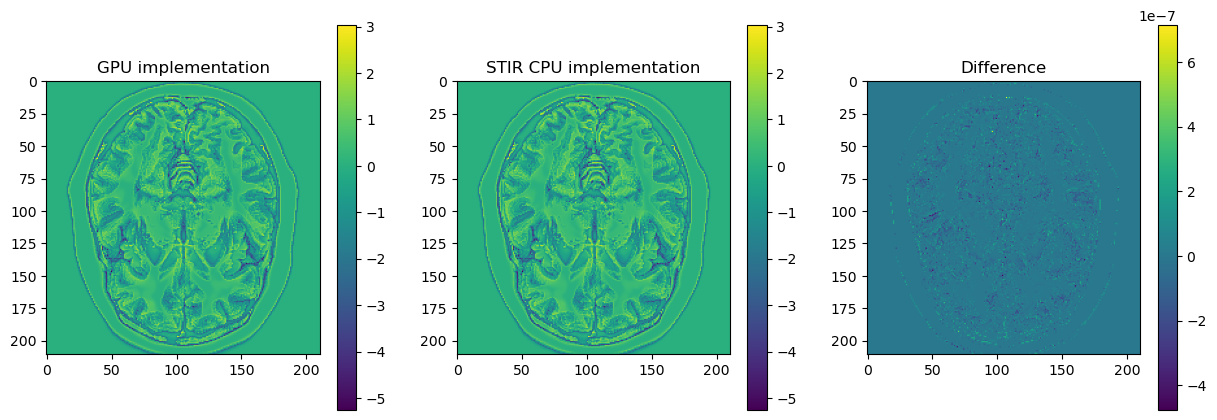

In [4]:
cp_img = cp.asarray(image.as_array())
with open('/home/user/sirf/compute_gradient.cu', 'r', encoding='utf-8') as file:
    content = file.read()
compute_gradient = cp.RawKernel(content, 'computeGradientKernel')
tmp_grad = cp.zeros(cp_image.shape, dtype=cp.float32)

start = time.time()
for i in range(1):
    compute_gradient((x_dim, y_dim, z_dim), (9, 9, 9), (tmp_value, cp_image, cp_weights, cp_kappa, cp_penalisation_factor, cp_gamma, cp_epsilon, z_dim, y_dim, x_dim))
time_to_compute_gradient = time.time()-start
print('Time to compute gradient:', time_to_compute_gradient) 

compute_gradient((x_dim, y_dim, z_dim), (9, 9, 9), (tmp_grad, cp_image, cp_weights, cp_kappa, cp_penalisation_factor, cp_gamma, cp_epsilon, z_dim, y_dim, x_dim))

#def plot_3d(z):
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.colorbar(ax[0].imshow(tmp_grad[z,:,:].get()), ax=ax[0])
ax[0].set_title('GPU implementation')
fig.colorbar(ax[1].imshow(sirf_grad.as_array()[z,:,:]), ax=ax[1])
ax[1].set_title('STIR CPU implementation')
fig.colorbar(ax[2].imshow(tmp_grad[z,:,:].get()-sirf_grad.as_array()[z,:,:]), ax=ax[2])
ax[2].set_title('Difference')
plt.show()

#interact(plot_3d, z=(0, tmp_grad.shape[0]-1, 1))

In [5]:
n_repeats = 100

start = time.time()
for i in range(n_repeats):
    grad = prior.get_gradient(image)
time_to_compute_gradient_cpu = time.time()-start

start = time.time()
for i in range(n_repeats):
    val = prior.get_value(image)
time_to_compute_value_cpu = time.time()-start

start = time.time()
for i in range(n_repeats):
    compute_gradient((x_dim, y_dim, z_dim), (9, 9, 9), (tmp_grad, cp_image, cp_weights, cp_kappa, cp_penalisation_factor, cp_gamma, cp_epsilon, z_dim, y_dim, x_dim))
time_to_compute_gradient_gpu = time.time()-start

start = time.time()
for i in range(n_repeats):
    compute_value((x_dim, y_dim, z_dim), (9, 9, 9), (tmp_value, cp_image, cp_weights, cp_kappa, cp_penalisation_factor, cp_gamma, cp_epsilon, z_dim, y_dim, x_dim))
time_to_compute_value_gpu = time.time()-start

import os, platform, subprocess, re

# stolen from internet https://stackoverflow.com/questions/64526139/how-does-one-get-the-model-of-the-gpu-in-python-and-save-it-as-a-string
def get_mdl():
    line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
    line = line_as_bytes.decode("ascii")
    _, line = line.split(":", 1)
    line, _ = line.split("(")
    return line.strip()

# stolen from internet https://stackoverflow.com/questions/4842448/getting-processor-information-in-python
def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

print('Machine:', platform.machine())
print('System:', platform.system())
print('Release:', platform.release())
print('Version:', platform.version())
print('GPU:', get_mdl())
print('CPU:', get_processor_name())



print('Time to compute value CPU:', time_to_compute_value_cpu)
print('Time to compute value GPU:', time_to_compute_value_gpu)
print('Time to compute gradient CPU:', time_to_compute_gradient_cpu)
print('Time to compute gradient GPU:', time_to_compute_gradient_gpu)

Machine: x86_64
System: Linux
Release: 5.15.133.1-microsoft-standard-WSL2
Version: #1 SMP Thu Oct 5 21:02:42 UTC 2023
GPU: NVIDIA GeForce RTX 3090
CPU:  AMD Ryzen 9 5950X 16-Core Processor
Time to compute value CPU: 5.29967474937439
Time to compute value GPU: 0.0011098384857177734
Time to compute gradient CPU: 5.819860219955444
Time to compute gradient GPU: 0.001238107681274414


Further work:
* Add a flag for 2D computation (although I think it'd work as is)
* Compute the weights and store when initialising the prior?
* Add the wrapper dealing with memory allocation etc, I guess we'd only need to allocate new array for the outputs?
* Wrap it an integrate into SIRF/STIR?
